# Image Transfer Learning with ImageSet and Keras API

Using the high level transfer learning APIs, you can easily customize pretrained models for feature extraction or fine-tuning.
In this notebook, we will use a pre-trained Inception_V1 model. But we will operate on the pre-trained model to freeze first few layers, replace the classifier on the top, then fine tune the whole model. And we use the fine-tuned model to solve the dogs-vs-cats classification problem,

## Preparation

### 1. Get the dogs-vs-cats datasets

Download the image dataset from https://www.kaggle.com/c/dogs-vs-cats and decompress it. 

The following commands copy about 1100 images of cats and dogs into demo/cats and demo/dogs separately. 
```shell
mkdir -p demo/dogs
mkdir -p demo/cats
cp train/cat.7* demo/cats
cp train/dog.7* demo/dogs
```

### 2. Get the pre-trained Inception-V1 model

Download the pre-trained Inception-V1 model from [Zoo](https://s3-ap-southeast-1.amazonaws.com/bigdl-models/imageclassification/imagenet/bigdl_inception-v1_imagenet_0.4.0.model) 
 Alternatively, user may also download pre-trained caffe/Tensorflow/keras model.

## Load data

In [1]:
from zoo.common.nncontext import *
from zoo.feature.image import *
from zoo.pipeline.api.keras.layers import Input, Flatten, Dense
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.net import *
from zoo.feature.common import ChainedPreprocessing
from bigdl.optim.optimizer import SGD

sparkConf = create_spark_conf().setMaster("local[4]").setAppName("testNNClassifer")
sc = init_nncontext(sparkConf)

Please manually set model_path and image_path for training

1. model_path = path to the pre-trained models. (E.g. path/to/model/bigdl_inception-v1_imagenet_0.4.0.model)

2. cats_path = path to the folder of the cats training images.

3. dogs_path = path to the folder of the dogs training images.


In [2]:
model_path = "/tmp/demo/bigdl_inception-v1_imagenet_0.4.0.model"
cats_path = "/tmp/demo/cats"
dogs_path = "/tmp/demo/dogs"


In [3]:
# read images and random split to train and validation set.
cats_image_rdd = ImageSet.read(cats_path, sc).get_image(to_chw = False)
dogs_image_rdd = ImageSet.read(dogs_path, sc).get_image(to_chw = False)

cats_train_images, cats_test_images = cats_image_rdd.randomSplit([0.9, 0.1], 17)
dogs_train_images, dogs_test_images = dogs_image_rdd.randomSplit([0.9, 0.1], 17)

# generate labels for training images, dog as 0, cats as 1
cats_train_labels = cats_train_images.map(lambda i: np.ones([1]))
dogs_train_labels = dogs_train_images.map(lambda i: np.zeros([1]))

train_image_rdd = cats_train_images.union(dogs_train_images)
train_label_rdd = cats_train_labels.union(dogs_train_labels)

# generate DistributedImageSet
train_image_set = DistributedImageSet(train_image_rdd, train_label_rdd)

creating: createDistributedImageSet


Defines a function to plot the images and labels

In [4]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images, labels, prediction, cols=5):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    num = len(images)
    for i in range(0, num):
        ax = plt.subplot(num/cols + 1, cols, 1 + i)
        ax.imshow(images[i].astype(dtype=np.uint8)[...,::-1])
        title = "label = " + str(labels[i])
        if len(prediction) > 0:
            title = title + ",prediction=" + str(prediction[i])

        ax.set_title(title, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

samples of cats training images


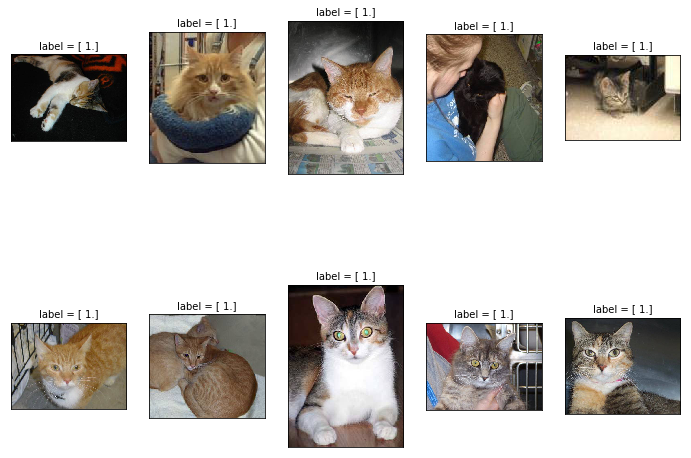

In [5]:
num_samples = 10
imgs = cats_train_images.take(num_samples)
labels = cats_train_labels.take(num_samples)
print("samples of cats training images")
plot_images_labels_prediction(imgs, labels, prediction=[], cols=5)

samples of dogs training images


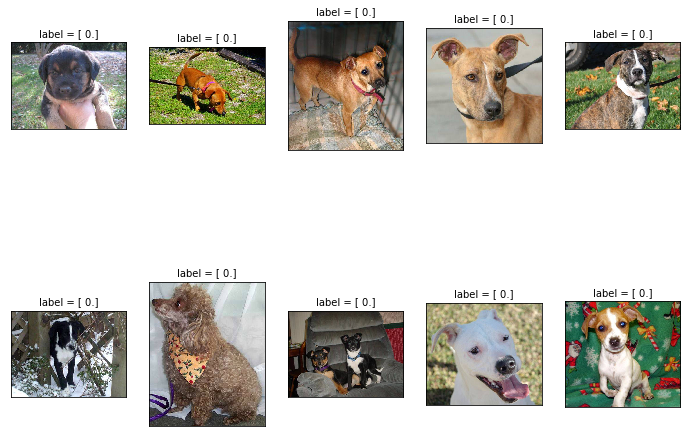

In [6]:
imgs = dogs_train_images.take(num_samples)
labels = dogs_train_labels.take(num_samples)
print("samples of dogs training images")
plot_images_labels_prediction(imgs, labels, prediction=[], cols=5)

Define Transformers for image preprocessing, including resize, normalize and convert to Samples.

In [7]:
transformer = ChainedPreprocessing(
    [ImageBytesToMat(), ImageResize(256, 256), ImageCenterCrop(224, 224),
     ImageChannelNormalize(0.485, 0.456, 0.406, 0.229, 0.224, 0.225),
     ImageMatToTensor(), ImageSetToSample(target_keys=['label'])])

creating: createImageBytesToMat
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageSetToSample
creating: createChainedPreprocessing


Load Pretrained Inception model. While keeping the primary layers from the pretrained model, a few extra layers are added to adapt the model to the new model. Analytics Zoo provides convenient method like `new_graph` and `freeze_up_to`.

In [8]:

full_model = Net.load_bigdl(model_path)
model = full_model.new_graph(["pool5/drop_7x7_s1"])

# freeze weights of previous layers, so they are not changed during training.
model.freeze_up_to(["pool4/3x3_s2"])

inputNode = Input(name="input", shape=(3, 224, 224))
inception = model.to_keras()(inputNode)
flatten = Flatten()(inception)
logits = Dense(2, activation="softmax")(flatten)
dog_cat_model = Model(inputNode, logits)

dog_cat_model.compile(optimizer=SGD(learningrate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


creating: createZooKerasInput
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasModel
creating: createDefault
creating: createSGD
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createZooKerasAccuracy


In [9]:
# model training
batch_size = 16
train_image_set = train_image_set.transform(transformer)
print("training...")
dog_cat_model.fit(train_image_set, batch_size=batch_size, nb_epoch=2)
print("training finished")

training...
training finished


Evalutate the trained model with test dataset.

In [10]:
# generate labels for test images
cats_test_labels = cats_test_images.map(lambda i: np.ones([1]))
dogs_test_labels = dogs_test_images.map(lambda i: np.zeros([1]))

test_image_rdd = cats_test_images.union(dogs_test_images)
test_label_rdd = cats_test_labels.union(dogs_test_labels)

# generate DistributedImageSet and apply transform
test_image_set = DistributedImageSet(test_image_rdd, test_label_rdd)
test_image_set = test_image_set.transform(transformer)

# evaluate accuracy
accuracy = dog_cat_model.evaluate(test_image_set, batch_size=batch_size)
print(accuracy[0])

creating: createDistributedImageSet
Evaluated result: 0.9631147384643555, total_num: 244, method: Top1Accuracy


creating: createDistributedImageSet
samples of test images


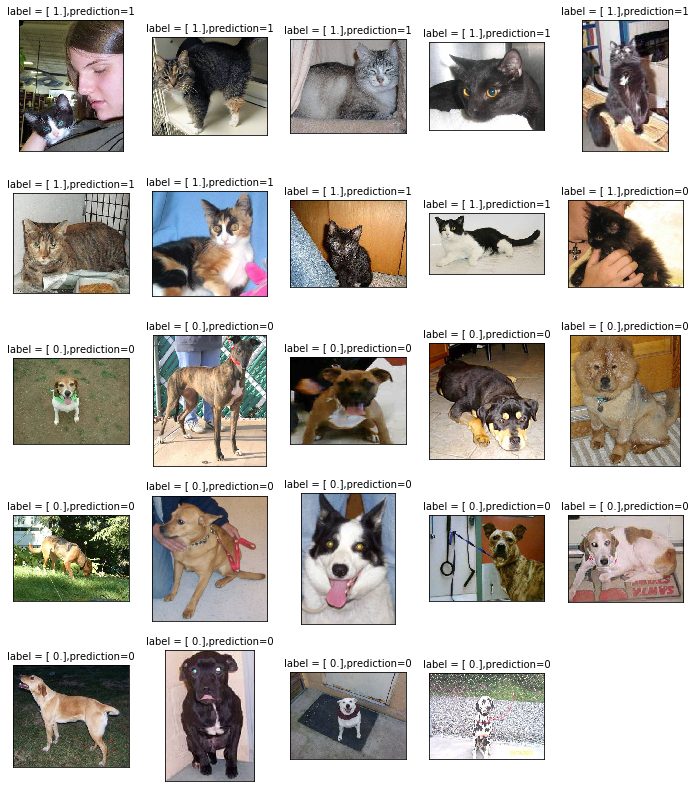

In [15]:
# get some samples from test images for prediction
sample_cat_images = cats_test_images.sample(withReplacement=False, fraction=0.1)
sample_dog_images = dogs_test_images.sample(withReplacement=False, fraction=0.1)

sample_cat_labels = sample_cat_images.map(lambda i: np.ones([1]))
sample_dog_labels = sample_dog_images.map(lambda i: np.zeros([1]))

sample_image_rdd = sample_cat_images.union(sample_dog_images)
sample_label_rdd = sample_cat_labels.union(sample_dog_labels)

sample_image_set = DistributedImageSet(sample_image_rdd, sample_label_rdd)
sample_image_set = sample_image_set.transform(transformer)

sample_images = sample_image_rdd.collect()
sample_labels = sample_label_rdd.collect()

prediction = dog_cat_model.predict(sample_image_set).get_predict().collect()
prediction_class = list(map(lambda x: np.argmax(x[1]), prediction))

print("samples of test images")
plot_images_labels_prediction(sample_images, sample_labels, prediction_class, cols=5)